In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1900

nband = 1100

nv = 200

dv = 0.005

tsfc =294

ng =6

nref =2

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

ng_refs = (/ 3 , 3 /) 

data wgt
     &     /0.7 , 0.7 , 0.7 , 0.7,
     &     0.7 , 0.8/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.8/

klin =6.5e-24

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

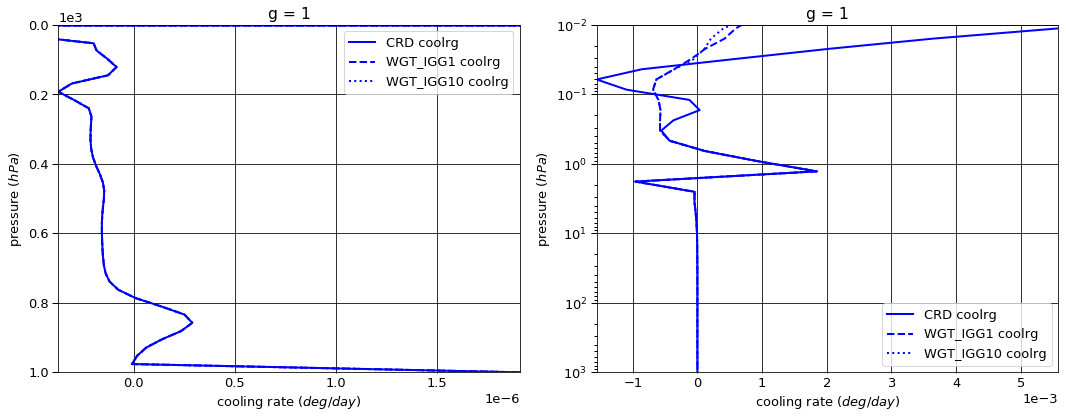

# Figure: cooling rate g-group 2

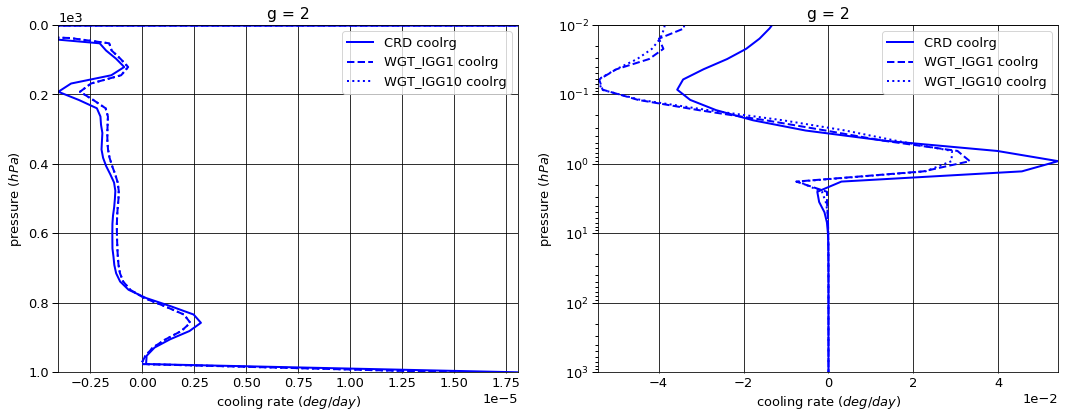

# Figure: cooling rate g-group 3

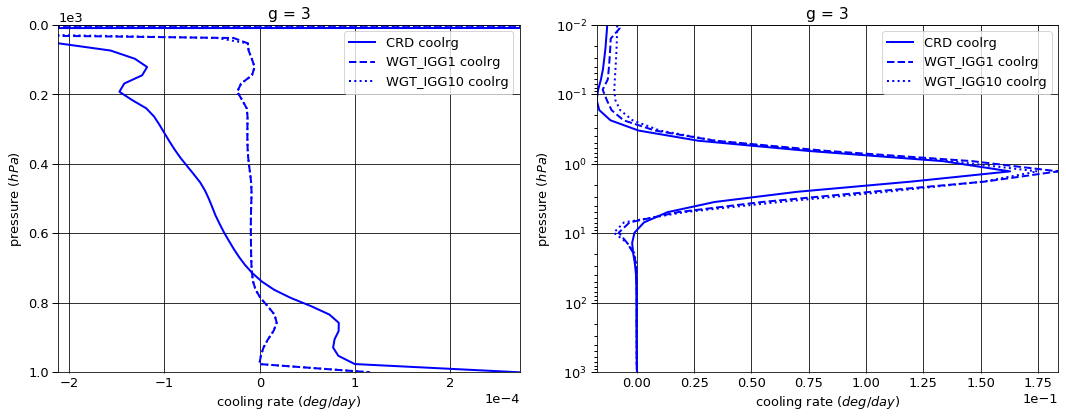

# Figure: cooling rate g-group 4

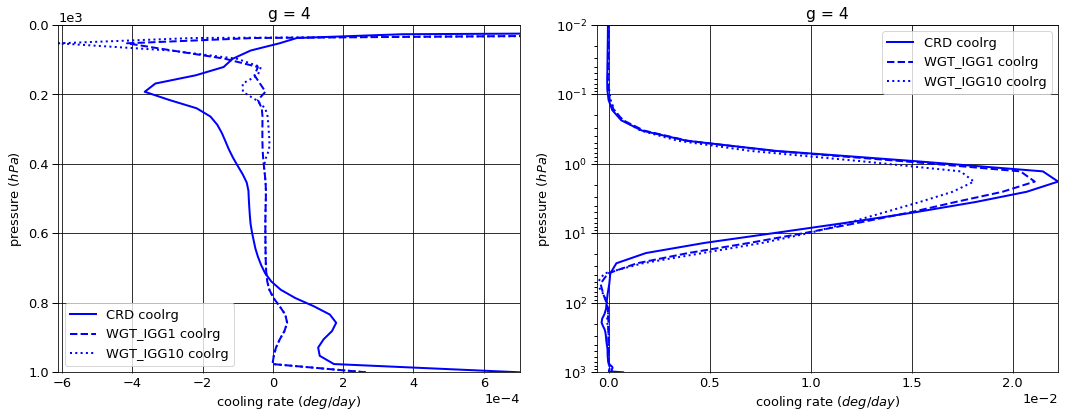

# Figure: cooling rate g-group 5

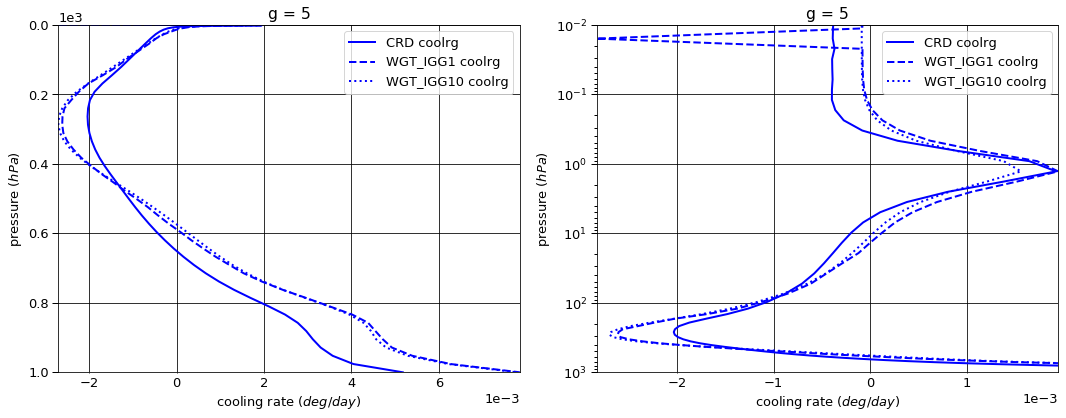

# Figure: cooling rate g-group 6

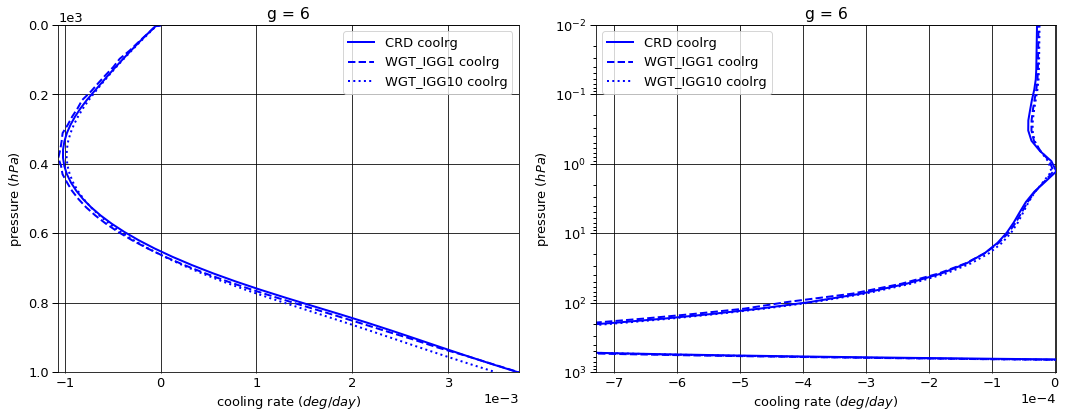

# Figure: cooling rate g-group total

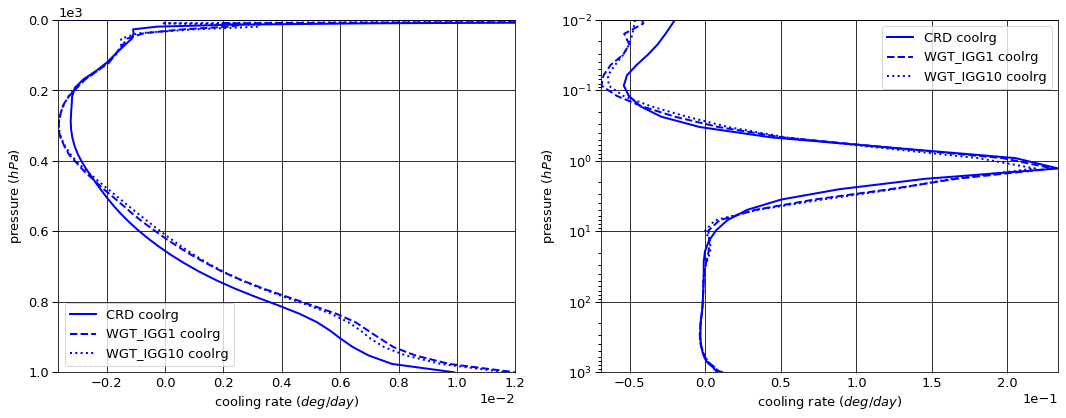

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000038  0.000000 -0.000038
  1013.0   76    -0.003145  0.003139 -0.000005
2 0.0      1     -0.003867  0.000000 -0.003867
  1013.0   76    -0.025010  0.024958 -0.000052
3 0.0      1     -0.035449  0.000000 -0.035449
  1013.0   76    -0.193344  0.188617 -0.004727
4 0.0      1     -0.023516  0.000000 -0.023516
  1013.0   76    -0.442258  0.436852 -0.005406
5 0.0      1     -0.321646  0.000000 -0.321646
  1013.0   76    -0.745497  0.423386 -0.322111
6 0.0      1     -5.100050  0.000000 -5.100050
  1013.0   76    -5.216198  0.144909 -5.071289


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000033  0.000000 -0.000033
  1013.0   76    -0.003145  0.003139 -0.000005
2 0.0      1     -0.001464  0.000000 -0.001464
  1013.0   76    -0.025010  0.024967 -0.000043
3 0.0      1     -0.041695  0.000000 -0.041695
  1013.0   76    -0.193344  0.193016 -0.000328
4 0.0      1     -0.024019  0.000000 -0.024019
  1013.0   76    -0.442258  0.441510 -0.000748
5 0.0      1     -0.138994  0.000000 -0.138994
  1013.0   76    -0.745497  0.661458 -0.084039
6 0.0      1     -5.104572  0.000000 -5.104572
  1013.0   76    -5.216198  0.134828 -5.081370


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000033  0.000000 -0.000033
  1013.0   76    -0.003145  0.003139 -0.000005
2 0.0      1     -0.001337  0.000000 -0.001337
  1013.0   76    -0.025010  0.024967 -0.000043
3 0.0      1     -0.042054  0.000000 -0.042054
  1013.0   76    -0.193344  0.193016 -0.000328
4 0.0      1     -0.023337  0.000000 -0.023337
  1013.0   76    -0.442258  0.441510 -0.000748
5 0.0      1     -0.126906  0.000000 -0.126906
  1013.0   76    -0.745497  0.672372 -0.073125
6 0.0      1     -5.113208  0.000000 -5.113208
  1013.0   76    -5.216198  0.124658 -5.091541


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      4.656698e-06  0.000000  0.000005
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      2.402867e-03  0.000000  0.002403
  1013.0   76     0.000000e+00  0.000009  0.000009
3 0.0      1     -6.245820e-03  0.000000 -0.006246
  1013.0   76     0.000000e+00  0.004399  0.004399
4 0.0      1     -5.026530e-04  0.000000 -0.000503
  1013.0   76     0.000000e+00  0.004658  0.004658
5 0.0      1      1.826519e-01  0.000000  0.182652
  1013.0   76     0.000000e+00  0.238072  0.238072
6 0.0      1     -4.522700e-03  0.000000 -0.004523
  1013.0   76    -8.881784e-16 -0.010081 -0.010081


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      4.819886e-06  0.000000  0.000005
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      2.529369e-03  0.000000  0.002529
  1013.0   76     0.000000e+00  0.000009  0.000009
3 0.0      1     -6.605081e-03  0.000000 -0.006605
  1013.0   76     0.000000e+00  0.004399  0.004399
4 0.0      1      1.789670e-04  0.000000  0.000179
  1013.0   76     0.000000e+00  0.004658  0.004658
5 0.0      1      1.947393e-01  0.000000  0.194739
  1013.0   76     0.000000e+00  0.248986  0.248986
6 0.0      1     -1.315810e-02  0.000000 -0.013158
  1013.0   76    -8.881784e-16 -0.020252 -0.020252

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.153059
  1001.112500 75     0.000002
2 0.000312    1     -0.011531
  1001.112500 75     0.000018
3 0.000312    1     -0.011818
  1001.112500 75     0.000273
4 0.000312    1     -0.000046
  1001.112500 75     0.000703
5 0.000312    1     -0.000371
  1001.112500 75     0.005174
6 0.000312    1     -0.000026
  1001.112500 75     0.003735


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.252444
  1001.112500 75     0.000002
2 0.000312    1     -0.038782
  1001.112500 75     0.000015
3 0.000312    1     -0.010593
  1001.112500 75     0.000116
4 0.000312    1     -0.000037
  1001.112500 75     0.000264
5 0.000312    1     -0.000083
  1001.112500 75     0.007849
6 0.000312    1     -0.000024
  1001.112500 75     0.003744


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.258315
  1001.112500 75     0.000002
2 0.000312    1     -0.042692
  1001.112500 75     0.000015
3 0.000312    1     -0.008088
  1001.112500 75     0.000116
4 0.000312    1     -0.000019
  1001.112500 75     0.000264
5 0.000312    1     -0.000088
  1001.112500 75     0.007782
6 0.000312    1     -0.000023
  1001.112500 75     0.003504


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      9.938437e-02
  1001.112500 75     4.235165e-22
2 0.000312    1     -2.725082e-02
  1001.112500 75    -3.001576e-06
3 0.000312    1      1.224983e-03
  1001.112500 75    -1.571201e-04
4 0.000312    1      8.176108e-06
  1001.112500 75    -4.382811e-04
5 0.000312    1      2.877340e-04
  1001.112500 75     2.675089e-03
6 0.000312    1      2.028153e-06
  1001.112500 75     8.599900e-06


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.052559e-01
  1001.112500 75     4.235165e-22
2 0.000312    1     -3.116016e-02
  1001.112500 75    -3.001576e-06
3 0.000312    1      3.729828e-03
  1001.112500 75    -1.571201e-04
4 0.000312    1      2.674913e-05
  1001.112500 75    -4.382811e-04
5 0.000312    1      2.825370e-04
  1001.112500 75     2.608105e-03
6 0.000312    1      3.560453e-06
  1001.112500 75    -2.311496e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.484565,0.000000,-5.484565
1013.0,76,-6.625452,1.221862,-5.403591



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.310776,0.00000,-5.310776
1013.0,76,-6.625452,1.45892,-5.166533



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.306875,0.000000,-5.306875
1013.0,76,-6.625452,1.459663,-5.165789



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.737882e-01,0.000000,0.173788
1013.0,76,-8.881784e-16,0.237058,0.237058



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.776893e-01,0.000000,0.177689
1013.0,76,-8.881784e-16,0.237802,0.237802


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.129267
1001.112500,75,0.009905



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.202924
1001.112500,75,0.011990



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.207406
1001.112500,75,0.011683



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.073656
1001.112500,75,0.002085



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.078138
1001.112500,75,0.001779


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000568,0.000397
2,0.004291,0.003203
3,0.032091,0.025151
4,0.071123,0.057827
5,0.076623,0.112104
6,0.815305,0.801318


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,9.493630e-18
2,1.027587e-19
3,1.112255e-21
4,6.007831e-22
5,6.500239e-24
6,3.693103e-32


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,9.493630e-18,NaN,0.000568,0.000397,0.000568,0.000397,1.0
2,1.027587e-19,1.082396e-02,0.004291,0.003203,0.004859,0.003600,1.0
3,1.112255e-21,1.082396e-02,0.032091,0.025151,0.036950,0.028751,1.0
4,6.007831e-22,5.401485e-01,0.071123,0.057827,0.108073,0.086578,50.0
5,6.500239e-24,1.081961e-02,0.076623,0.112104,0.184695,0.198682,50.0
6,3.693103e-32,5.681487e-09,0.815305,0.801318,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog         ratio        taulyr
layer g pressure                                                           
1     1 0.000312     1.609477e-16  1.389496e-17  1.158317e+01  6.184470e-01
      2 0.000312     5.957045e-19  8.007741e-20  7.439108e+00  2.334511e-03
      3 0.000312     2.408073e-21  3.817384e-22  6.308176e+00  9.529175e-06
      4 0.000312     1.234868e-23  1.013137e-23  1.218856e+00  6.184628e-08
      5 0.000312     9.848023e-24  8.832403e-25  1.114988e+01  3.789383e-08
      6 0.000312     4.454789e-26  8.477699e-32  5.254715e+05  1.886507e-10
2     1 0.000750     1.609178e-16  1.393110e-17  1.155098e+01  2.490807e-01
      2 0.000750     5.971669e-19  8.039320e-20  7.428077e+00  9.426944e-04
      3 0.000750     2.418820e-21  3.856167e-22  6.272600e+00  3.856745e-06
      4 0.000750     1.251226e-23  1.028340e-23  1.216744e+00  2.525225e-08
      5 0.000750     9.878826e-24  8.862441e-25  1.114684e+01  1.531103e-08
      6 0.000750     4.472313e-26  1.055689e-31  4.236391e+05  7.628492e-11
3     1 0.001052     1.608562e-16  1.400694e-17  1.148404e+01  3.492463e-01
      2 0.001052     6.001766e-19  8.091899e-20  7.417005e+00  1.328792e-03
      3 0.001052     2.438273e-21  3.894559e-22  6.260715e+00  5.452804e-06
      4 0.001052     1.272392e-23  1.047006e-23  1.215268e+00  3.602385e-08
      5 0.001052     9.943880e-24  8.916599e-25  1.115210e+01  2.161298e-08
      6 0.001052     4.509461e-26  1.153743e-31  3.908548e+05  1.078695e-10
4     1 0.001476     1.607909e-16  1.408780e-17  1.141349e+01  4.898649e-01
      2 0.001476     6.034198e-19  8.150493e-20  7.403475e+00  1.874413e-03
      3 0.001476     2.459785e-21  3.942537e-22  6.239091e+00  7.718899e-06
      4 0.001476     1.297426e-23  1.069337e-23  1.213300e+00  5.155367e-08
      5 0.001476     1.001388e-23  8.976011e-25  1.115627e+01  3.053371e-08
      6 0.001476     4.549538e-26  1.265027e-31  3.596396e+05  1.526742e-10
5     1 0.002070     1.607253e-16  1.416944e-17  1.134309e+01  6.869521e-01
      2 0.002070     6.067370e-19  8.214794e-20  7.385907e+00  2.643823e-03
      3 0.002070     2.482629e-21  4.002406e-22  6.202842e+00  1.093108e-05
      4 0.002070     1.326600e-23  1.095750e-23  1.210678e+00  7.397625e-08
      5 0.002070     1.008524e-23  9.038658e-25  1.115789e+01  4.313110e-08
      6 0.002070     4.590487e-26  1.368053e-31  3.355488e+05  2.160662e-10
6     1 0.002904     1.606593e-16  1.425191e-17  1.127282e+01  9.634363e-01
      2 0.002904     6.101385e-19  8.285818e-20  7.363648e+00  3.730000e-03
      3 0.002904     2.507189e-21  4.078150e-22  6.147858e+00  1.549407e-05
      4 0.002904     1.361444e-23  1.127772e-23  1.207198e+00  1.065751e-07
      5 0.002904     1.015800e-23  9.105586e-25  1.115579e+01  6.093855e-08
      6 0.002904     4.632339e-26  1.467593e-31  3.156418e+05  3.058475e-10
7     1 0.004074     1.605925e-16  1.433538e-17  1.120253e+01  1.351232e+00
      2 0.004074     6.136427e-19  8.365981e-20  7.334976e+00  5.263528e-03
      3 0.004074     2.534023e-21  4.175199e-22  6.069227e+00  2.198585e-05
      4 0.004074     1.404124e-23  1.167571e-23  1.202603e+00  1.543418e-07
      5 0.004074     1.023234e-23  9.178394e-25  1.114829e+01  8.611074e-08
      6 0.004074     4.675184e-26  1.560356e-31  2.996228e+05  4.330030e-10
8     1 0.005714     1.605247e-16  1.442008e-17  1.113203e+01  1.894988e+00
      2 0.005714     6.172754e-19  8.458696e-20  7.297524e+00  7.428856e-03
      3 0.005714     2.563917e-21  4.300514e-22  5.961885e+00  3.123998e-05
      4 0.005714     1.457680e-23  1.218181e-23  1.196604e+00  2.250456e-07
      5 0.005714     1.030849e-23  9.259326e-25  1.113309e+01  1.216909e-07
      6 0.005714     4.719146e-26  1.641551e-31  2.874808e+05  6.130758e-10
9     1 0.008015     1.604554e-16  1.450635e-17  1.106104e+01  2.657612e+00
      2 0.008015     6.210731e-19  8.568603e-20  7.248241e+00  1.048863e-02
      3 0.008015     2.597973e-21  4.462666e-22  5.821571e+00  4.447461e-0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
